In [2]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *
from plot_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import *

%load_ext autoreload
%autoreload 2


In [3]:
torch.cuda.set_device(0)

## check the basic model

In [33]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=7900, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(), no_ffn=(), linear_ffn=(), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(6.0284e-05, grad_fn=<MeanBackward0>),
 tensor(2.2295, grad_fn=<MeanBackward0>))

In [34]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1)

(tensor([115.1096,  25.8052,  17.2501,  26.1566,  31.0634,  30.8269,  30.2706,
          16.7018,  31.1896,  30.9548], grad_fn=<LinalgVectorNormBackward0>),
 tensor([124.8525,  34.4345,  16.2137,  34.2331, 212.3472,  52.3510,  46.9091,
          17.7935,  46.7513,  64.3132], grad_fn=<LinalgVectorNormBackward0>),
 tensor([159.2860, 135.2962,  33.9757, 135.7168, 324.4321, 157.3942, 143.3436,
          31.9406, 141.7073, 154.7521], grad_fn=<LinalgVectorNormBackward0>))

In [36]:
outputs_list[0]['value_states'][0, 0, :10, :].norm(dim=-1)

tensor([31.0228,  6.3542,  6.4011,  6.8476,  6.8099,  7.5087,  7.9404,  7.0742,
         8.2516,  8.6678], grad_fn=<LinalgVectorNormBackward0>)

## check no_attn_0_2, no massive norms

In [3]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(0, 2), no_ffn=(), linear_ffn=(), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

In [ ]:
ds.update_decoder()
ds.decode(x[0, :10].numpy())

In [5]:
outputs_list[0].keys()

dict_keys(['embed', 'embed_post_pos', 'input', 'no_attn', 'mlp_input_pre_norm', 'mlp_input_norm', 'mlp_input', 'mlp_output', 'mlp_output_add_res', 'output'])

In [7]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1)

tensor([38.8765, 25.9073, 16.2818, 26.6168, 37.8806, 33.6152, 31.2623, 16.7479,
        31.9314, 33.1829], grad_fn=<LinalgVectorNormBackward0>)

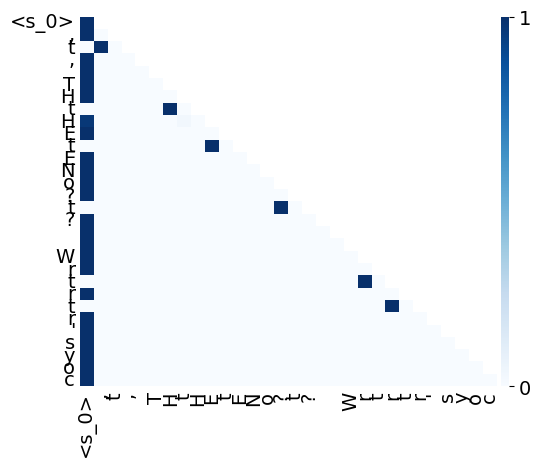

In [10]:
seq_indices = [0]
seq_len = 30
layer_idx = 1
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=14, titles=[], save_files_fn=[], fn=None)

## check no_ffn_0_2, it has a little bit of massive norm

In [12]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(), no_ffn=(0, 2), linear_ffn=(), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(9.0089e-05, grad_fn=<MeanBackward0>),
 tensor(2.2291, grad_fn=<MeanBackward0>))

In [25]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1)

(tensor([44.4960, 21.9510, 21.1645, 22.8749, 31.6391, 22.2314, 23.9569, 20.7630,
         24.9967, 22.6526], grad_fn=<LinalgVectorNormBackward0>),
 tensor([108.9156,  78.0992,  38.0919,  77.5689, 287.2232, 103.6656,  80.3773,
          29.7542,  77.9523, 101.4277], grad_fn=<LinalgVectorNormBackward0>),
 tensor([107.1088, 112.7952,  45.3268, 112.2579, 290.4570, 111.0459,  87.8368,
          27.6231,  85.3559, 102.9314], grad_fn=<LinalgVectorNormBackward0>))

In [24]:
ds.update_decoder()
ds.decode(x[0, :10].numpy())

['<s_0>', ',', 't', ',', '\\n', 'T', 'H', 't', 'H', 'E']

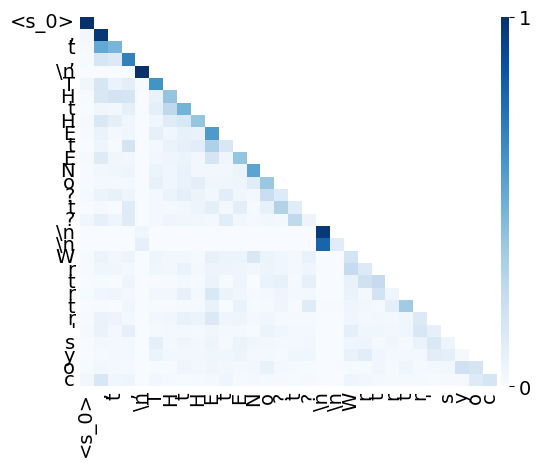

In [23]:
seq_indices = [0]
seq_len = 30
layer_idx = 0
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=14, titles=[], save_files_fn=[], fn=None)

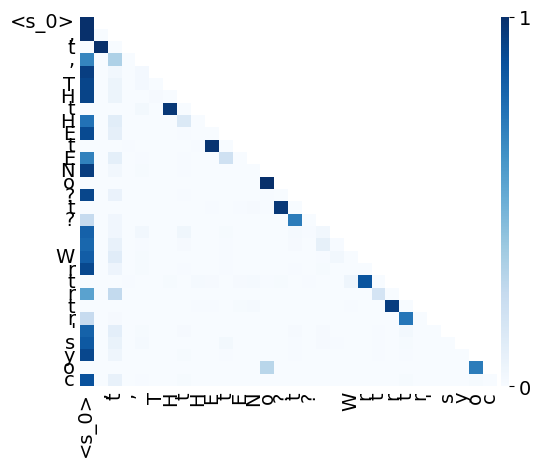

In [17]:
seq_indices = [0]
seq_len = 30
layer_idx = 1
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=14, titles=[], save_files_fn=[], fn=None)

## check no_attn_0_2_linear_ffn_0_2, no massive norms

In [4]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(0, 2), no_ffn=(), linear_ffn=(0, 2), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(5.1667e-05, grad_fn=<MeanBackward0>),
 tensor(2.2290, grad_fn=<MeanBackward0>))

In [6]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1)

(tensor([38.1792, 24.1465, 17.3182, 23.3907, 27.2928, 25.7511, 25.1501, 15.8870,
         24.6955, 26.2703], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 74.1422, 143.7439,  32.9071, 154.1164, 200.9297, 108.0317, 101.2918,
          21.8555, 103.2377,  94.2243], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 88.1585, 153.1884,  37.0261, 163.7854, 218.6816, 125.2441, 117.2649,
          28.8842, 119.1065, 110.2235], grad_fn=<LinalgVectorNormBackward0>))

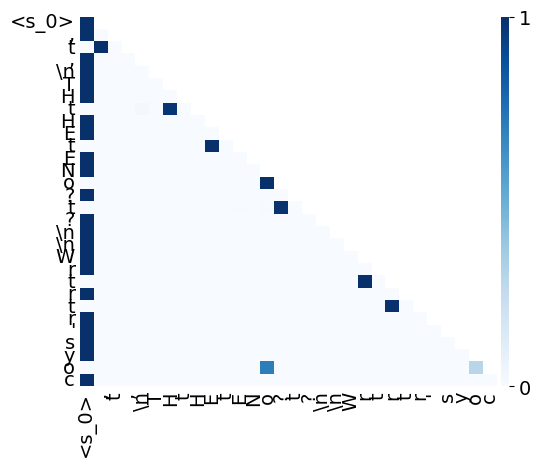

In [7]:
seq_indices = [0]
seq_len = 30
layer_idx = 1
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=14, titles=[], save_files_fn=[], fn=None)

In [9]:
x[0, 13]

tensor(53)

In [11]:
ds.cond[53, ds.idxs]

array([0.061704  , 0.00457461, 0.12362078])

In [8]:
ds.decode(x[0, :30].numpy())

['<s_0>',
 ',',
 't',
 ',',
 '\\n',
 'T',
 'H',
 't',
 'H',
 'E',
 't',
 'E',
 'N',
 'o',
 '?',
 't',
 '?',
 '\\n',
 '\\n',
 'W',
 'r',
 't',
 'r',
 't',
 'r',
 "'",
 's',
 'y',
 'o',
 'c']

## check no_attn_0_2_linear_ffn_0_

In [43]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(0, 2), no_ffn=(), linear_ffn=(0, ), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(4.4784e-05, grad_fn=<MeanBackward0>),
 tensor(2.2296, grad_fn=<MeanBackward0>))

In [44]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1)

(tensor([40.4606, 22.8788, 17.6063, 22.8385, 25.3048, 24.2606, 25.3399, 18.0332,
         25.7131, 24.7383], grad_fn=<LinalgVectorNormBackward0>),
 tensor([59.4440, 41.8609, 36.7028, 40.4079, 79.2875, 67.6885, 51.4139, 29.4995,
         50.7789, 54.7241], grad_fn=<LinalgVectorNormBackward0>),
 tensor([147.2514, 160.0045,  46.8811, 156.6415, 333.5859, 182.3857, 159.5345,
          35.5956, 158.5288, 164.7645], grad_fn=<LinalgVectorNormBackward0>))

In [45]:
outputs_list[1]['value_states'][0, 0, :10, :].norm(dim=-1)

tensor([ 2.3059, 32.2283, 14.9221, 31.9373, 20.1936, 22.7365, 23.6807, 15.3340,
        22.9933, 25.1554], grad_fn=<LinalgVectorNormBackward0>)

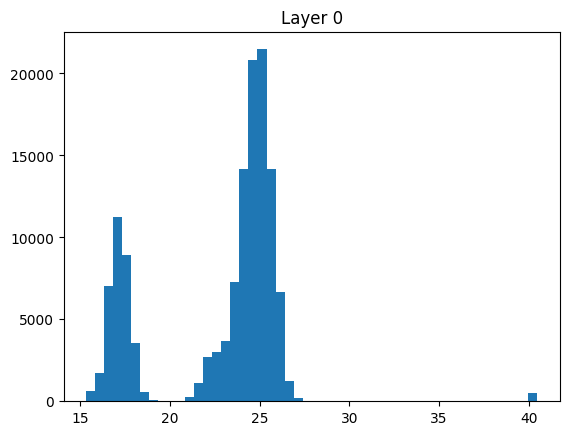

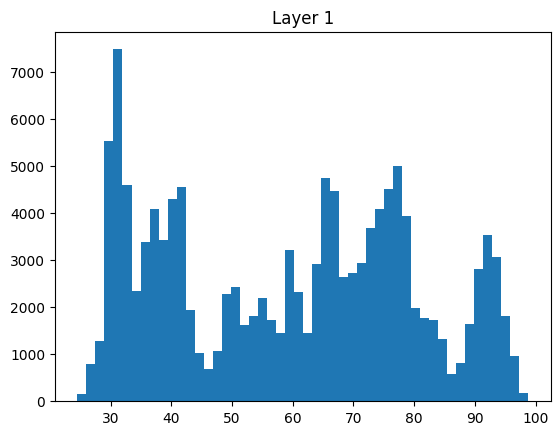

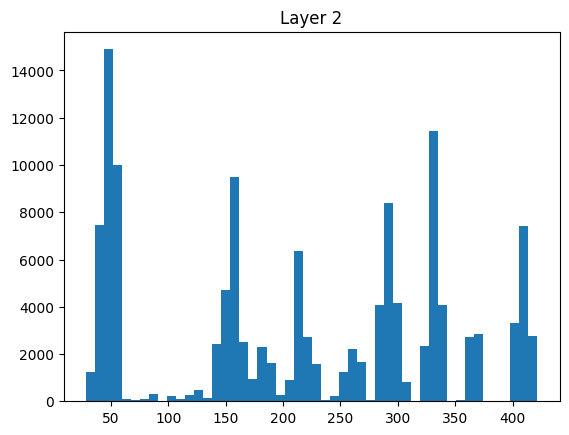

In [8]:
for layer_idx in range(3):
    plt.hist(outputs_list[layer_idx]['output'].norm(dim=-1).detach().flatten().numpy(), bins=50)
    plt.title(f"Layer {layer_idx}")
    plt.show()

## check no_attn_2_ 

In [40]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(2, ), no_ffn=(), linear_ffn=(), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(4.1686e-05, grad_fn=<MeanBackward0>),
 tensor(2.2291, grad_fn=<MeanBackward0>))

In [41]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1)

(tensor([135.6272,  27.2625,  16.3049,  28.2031,  49.5698,  33.8267,  33.0718,
          15.3098,  33.0708,  34.1695], grad_fn=<LinalgVectorNormBackward0>),
 tensor([156.7260,  51.7720,  39.9628,  52.1963, 192.7954,  90.4094,  76.0532,
          34.9722,  74.7080,  99.1726], grad_fn=<LinalgVectorNormBackward0>),
 tensor([208.7527, 169.5910,  53.9444, 166.6147, 374.8181, 211.8398, 185.5391,
          47.7054, 182.6678, 199.1977], grad_fn=<LinalgVectorNormBackward0>))

In [42]:
outputs_list[1]['value_states'][0, 0, :10, :].norm(dim=-1)

tensor([ 0.7551, 28.5901, 10.6723, 28.4080, 16.7570, 20.8605, 24.4004, 11.8640,
        23.9386, 24.3867], grad_fn=<LinalgVectorNormBackward0>)

## check no_ffn_0_no_attn_2, a little massive norm

In [37]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(2, ), no_ffn=(0, ), linear_ffn=(), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(5.8158e-05, grad_fn=<MeanBackward0>),
 tensor(2.2299, grad_fn=<MeanBackward0>))

In [38]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1)

(tensor([23.2225, 22.4092, 38.1455, 23.6836, 23.1886, 22.4979, 23.7242, 25.3260,
         25.1855, 22.2953], grad_fn=<LinalgVectorNormBackward0>),
 tensor([58.2499, 34.3160, 33.7712, 39.8098, 65.5969, 48.6052, 42.3164, 26.0195,
         42.1879, 50.9351], grad_fn=<LinalgVectorNormBackward0>),
 tensor([180.5119, 140.9952,  48.0280, 146.6687, 324.9738, 166.0192, 139.3074,
          44.1016, 137.4962, 180.8871], grad_fn=<LinalgVectorNormBackward0>))

In [39]:
outputs_list[1]['value_states'][0, 0, :10, :].norm(dim=-1)

tensor([2.7670, 6.5755, 7.8973, 7.3882, 6.1860, 7.0595, 8.3362, 8.3286, 8.1623,
        7.0524], grad_fn=<LinalgVectorNormBackward0>)

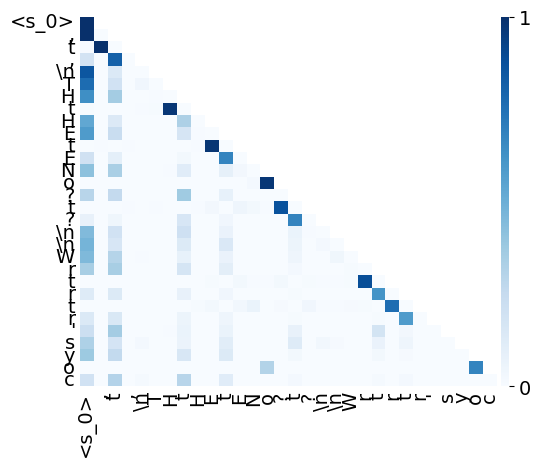

In [6]:
seq_indices = [0]
seq_len = 30
layer_idx = 0
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=14, titles=[], save_files_fn=[], fn=None)

## check linear+mlp+tf+tf

In [49]:
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=4, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(0, 1), no_ffn=(), linear_ffn=(0, ), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(4.1953e-05, grad_fn=<MeanBackward0>),
 tensor(2.2292, grad_fn=<MeanBackward0>))

In [50]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1), outputs_list[3]['output'][0, :10, :].norm(dim=-1)

(tensor([40.6443, 23.6674, 20.2203, 23.7386, 25.1271, 24.0477, 25.8718, 19.8733,
         25.9966, 24.6681], grad_fn=<LinalgVectorNormBackward0>),
 tensor([56.2690, 29.3179, 16.5614, 28.8394, 37.6781, 33.3827, 33.3189, 15.6791,
         32.7442, 37.5534], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 91.1140,  43.1320,  38.5818,  42.5922, 235.9493,  77.5540,  60.7566,
          32.6257,  59.5481,  82.6439], grad_fn=<LinalgVectorNormBackward0>),
 tensor([167.5824, 175.6895,  42.8134, 173.4870, 397.8076, 206.8916, 165.5148,
          35.2740, 164.5944, 201.9467], grad_fn=<LinalgVectorNormBackward0>))

In [51]:
outputs_list[2]['value_states'][0, 0, :10, :].norm(dim=-1)

tensor([ 0.7483, 24.4160, 12.0367, 24.2869, 20.5863, 19.8544, 21.3601, 12.7943,
        20.6985, 21.3367], grad_fn=<LinalgVectorNormBackward0>)

## check linear+mlp+tf+mlp

In [13]:
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=4, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(0, 1, 3), no_ffn=(), linear_ffn=(0, ), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(4.2615e-05, grad_fn=<MeanBackward0>),
 tensor(2.2296, grad_fn=<MeanBackward0>))

In [14]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1), outputs_list[3]['output'][0, :10, :].norm(dim=-1)

(tensor([40.6481, 23.7285, 20.8490, 23.9043, 25.3568, 23.8814, 26.2096, 20.4924,
         26.2645, 24.9040], grad_fn=<LinalgVectorNormBackward0>),
 tensor([55.9421, 28.2321, 16.3494, 27.6968, 33.5700, 32.9635, 34.5085, 16.2524,
         33.9783, 36.7552], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 84.6962,  57.1014,  39.9601,  56.4133, 147.1966,  84.2146,  66.4896,
          37.0053,  65.6223,  77.9580], grad_fn=<LinalgVectorNormBackward0>),
 tensor([182.4217, 166.4123,  51.1866, 164.6142, 370.0376, 205.3364, 170.8746,
          36.2978, 170.2904, 197.3531], grad_fn=<LinalgVectorNormBackward0>))

(array([ 1565., 13720., 16183.,  2214.,    27.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,    17.,   148.,   569.,  2262.,
         3209.,  1143.,  1119.,  3692.,  6485., 11141., 15595., 14315.,
        13156.,  9142.,  4108.,  1658.,  1764.,  3197.,  2892.,  1177.,
           62.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   512.]),
 array([14.14191723, 14.97792053, 15.81392288, 16.64992714, 17.48592949,
        18.32193184, 19.1579361 , 19.99393845, 20.8299408 , 21.66594505,
        22.5019474 , 23.33795166, 24.17395401, 25.00995636, 25.84596062,
        26.68196297, 27.51796532, 28.35396957, 29.18997192, 30.02597618,
        30.86197853, 31.69798088, 32.53398514, 33.36998749, 34.20598984,
        35.04199219, 35.87799835, 36.7140007 , 37.55000305, 38.3860054 ,
        39.22200775, 40.0580101 , 40.89401627, 41.73001862, 42.56602097,
        43.40202332, 44.2380256

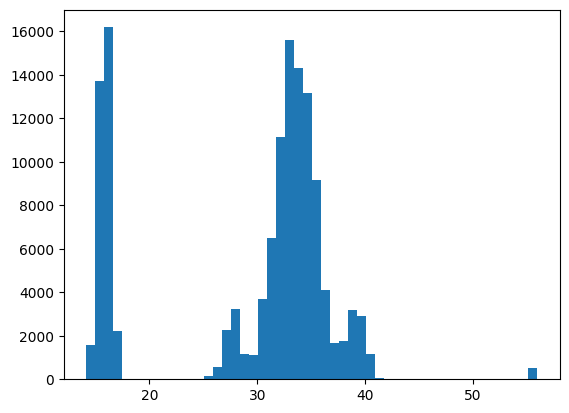

In [19]:
plt.hist(outputs_list[1]['output'][:, :, :].norm(dim=-1).detach().cpu().numpy().flatten(), bins=50)

In [6]:
outputs_list[2]['value_states'][0, 0, :10, :].norm(dim=-1)

tensor([ 0.7698, 31.9540, 14.8189, 32.2902, 21.5673, 23.7614, 25.6416, 14.8674,
        24.7178, 25.2282], grad_fn=<LinalgVectorNormBackward0>)

## check linear+mlp+tf+linear

In [10]:
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=4, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(0, 1, 3), no_ffn=(), linear_ffn=(0, 3), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(5.2799e-05, grad_fn=<MeanBackward0>),
 tensor(2.2292, grad_fn=<MeanBackward0>))

In [11]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1), outputs_list[3]['output'][0, :10, :].norm(dim=-1)

(tensor([38.9838, 23.8566, 21.4434, 23.7087, 25.0418, 24.3045, 25.6963, 20.9165,
         26.1698, 24.8240], grad_fn=<LinalgVectorNormBackward0>),
 tensor([52.1013, 30.9743, 17.7974, 30.1184, 71.6974, 44.5217, 40.3873, 16.7854,
         40.2147, 49.8601], grad_fn=<LinalgVectorNormBackward0>),
 tensor([119.2774, 131.9052,  33.4192, 157.8665, 297.9724, 166.1855, 134.3986,
          25.3279, 132.5125, 170.6864], grad_fn=<LinalgVectorNormBackward0>),
 tensor([131.2804, 141.7015,  37.0505, 166.7996, 308.4468, 179.2408, 146.9517,
          32.0856, 145.0539, 180.9062], grad_fn=<LinalgVectorNormBackward0>))

In [12]:
outputs_list[2]['value_states'][0, 0, :10, :].norm(dim=-1)

tensor([ 3.6997, 24.6164, 14.0405, 24.9058,  3.2607, 16.3777, 17.7372, 12.3950,
        17.0602, 18.2603], grad_fn=<LinalgVectorNormBackward0>)

## check linear+linear+tf+linear

In [7]:
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=4, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(0, 1, 3), no_ffn=(), linear_ffn=(0, 1, 3), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(5.0254e-05, grad_fn=<MeanBackward0>),
 tensor(2.2287, grad_fn=<MeanBackward0>))

In [8]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1), outputs_list[3]['output'][0, :10, :].norm(dim=-1)

(tensor([37.2806, 23.5591, 21.8578, 23.2864, 26.0648, 24.4039, 24.8694, 20.5068,
         25.4366, 24.7694], grad_fn=<LinalgVectorNormBackward0>),
 tensor([53.5606, 26.0602, 18.0934, 25.4454, 33.6333, 29.6756, 29.3537, 17.4892,
         29.2598, 30.1949], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 84.3247, 130.8533,  33.3905, 153.5641, 270.9563, 123.0180, 117.7110,
          26.8301, 114.8092, 120.3399], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 98.1667, 142.0853,  36.2941, 164.0822, 282.9514, 140.6344, 132.3657,
          32.7631, 129.3667, 133.7655], grad_fn=<LinalgVectorNormBackward0>))

In [9]:
outputs_list[2]['value_states'][0, 0, :10, :].norm(dim=-1)

tensor([ 2.2278, 27.1770, 11.7087, 27.3111, 14.2232, 17.3791, 19.5609, 12.2040,
        19.0141, 19.3464], grad_fn=<LinalgVectorNormBackward0>)

## look closer to the functions of each parts of the no_attn_2_ model

In [9]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(2, ), no_ffn=(), linear_ffn=(), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(4.1686e-05, grad_fn=<MeanBackward0>),
 tensor(2.2291, grad_fn=<MeanBackward0>))

### check its attention weights

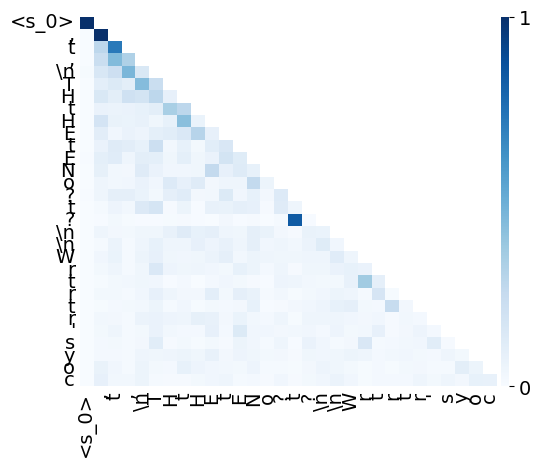

In [10]:
seq_indices = [0]
seq_len = 30
layer_idx = 0
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=14, titles=[], save_files_fn=[], fn=None)

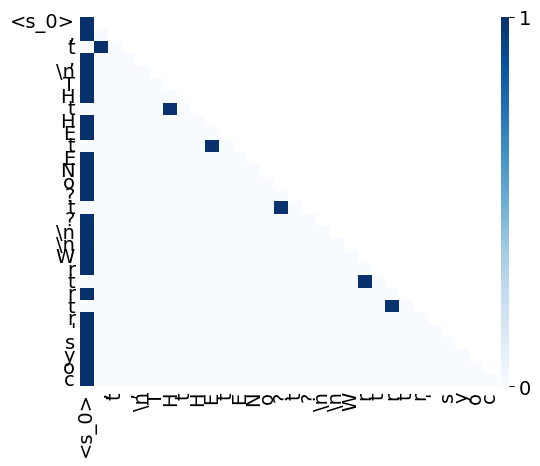

In [11]:
seq_indices = [0]
seq_len = 30
layer_idx = 1
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=14, titles=[], save_files_fn=[], fn=None)

### try interventions

### base

In [50]:
hook = check_embed(target_layers=[0, 1, 2], target_heads=[], target_mlp_layers=[])
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(4.1686e-05, grad_fn=<MeanBackward0>),
 tensor(2.2291, grad_fn=<MeanBackward0>))

In [39]:
outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['output'][0, :10, :].norm(dim=-1), outputs_list[2]['output'][0, :10, :].norm(dim=-1)

(tensor([135.6272,  27.2625,  16.3049,  28.2031,  49.5698,  33.8267,  33.0718,
          15.3098,  33.0708,  34.1695], grad_fn=<LinalgVectorNormBackward0>),
 tensor([156.7260,  51.7720,  39.9628,  52.1963, 192.7954,  90.4094,  76.0532,
          34.9722,  74.7080,  99.1726], grad_fn=<LinalgVectorNormBackward0>),
 tensor([208.7527, 169.5910,  53.9444, 166.6147, 374.8181, 211.8398, 185.5391,
          47.7054, 182.6678, 199.1977], grad_fn=<LinalgVectorNormBackward0>))

In [40]:
outputs_list[0]['value_states'][0, 0, :10, :].norm(dim=-1), outputs_list[1]['value_states'][0, 0, :10, :].norm(dim=-1)

(tensor([34.2958,  6.1452,  6.2056,  6.4343,  5.9675,  7.0639,  7.8390,  6.9145,
          7.6736,  7.3299], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 0.7551, 28.5901, 10.6723, 28.4080, 16.7570, 20.8605, 24.4004, 11.8640,
         23.9386, 24.3867], grad_fn=<LinalgVectorNormBackward0>))

In [51]:
pred, outputs_list = model.modified_forward_with_hook(x[:, 1:], hook)
outputs_list[0]['value_states'][0, 0, :10, :].norm(dim=-1), outputs_list[1]['value_states'][0, 0, :10, :].norm(dim=-1)

(tensor([18.5957,  6.5612,  6.1528,  6.2312,  7.4035,  7.8393,  7.2406,  8.3096,
          6.9588,  6.7851], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 7.8186, 10.3571, 28.5025, 16.9242, 21.4945, 24.0638, 12.5086, 24.1972,
         23.8232, 12.4388], grad_fn=<LinalgVectorNormBackward0>))

### study attn_0

In [52]:
hook = check_embed(target_layers=[0, 1, 2], target_heads=[(0, 0)], target_mlp_layers=[])
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(0.0001, grad_fn=<MeanBackward0>),
 tensor(2.2322, grad_fn=<MeanBackward0>))

In [53]:
outputs_list[0]['value_states'][0, 0, :10, :].norm(dim=-1), outputs_list[1]['value_states'][0, 0, :10, :].norm(dim=-1)

(tensor([34.2958,  6.1452,  6.2056,  6.4343,  5.9675,  7.0639,  7.8390,  6.9145,
          7.6736,  7.3299], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 9.4898, 28.7921, 11.7428, 28.4579, 16.6661, 20.9512, 24.5850, 12.5755,
         24.1318, 24.2405], grad_fn=<LinalgVectorNormBackward0>))